## Тестовое заадание от Сбер IDP.  
Выполненно Шарифуллиной Рамилей в Google Colab.


### Import modules

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from skimage import io
import matplotlib.pyplot as plt

import os
import pandas as pd

In [2]:
# зададим переменную `device` 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data extraction

In [3]:
# датасет лежит на моем гугл диске, он открыт для скачивания 
!mkdir datasets
!gdown --id 1-1p8EFtIQ_wjmY9yiKMUtUxBdI4mv5C0 -O datasets/imagewoof2.tgz
!tar -xzf datasets/imagewoof2.tgz -C datasets
!rm datasets/imagewoof2.tgz

mkdir: cannot create directory ‘datasets’: File exists
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-1p8EFtIQ_wjmY9yiKMUtUxBdI4mv5C0
To: /content/datasets/imagewoof2.tgz
100% 1.34G/1.34G [00:09<00:00, 138MB/s]


In [4]:
source_dir = '/content/datasets/imagewoof2' # путь к папке всего датасета
train_dir = os.path.join(source_dir, 'train') # путь к папке трейнового датасета
val_dir = os.path.join(source_dir, 'val') # путь к папке датасета для валидации
csv_file_dir = os.path.join(source_dir, 'noisy_imagewoof.csv') # путь к csv файлу

labels_csv = pd.read_csv(csv_file_dir) 
labels_csv.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False


### Dataset and DataLoader

In [5]:
# классы были наименованы согласно описанию датасета в https://github.com/fastai/imagenette
classes = ['Australian terrier', 
           'Border terrier', 
           'Samoyed', 
           'Beagle', 
           'Shih-Tzu', 
           'English foxhound', 
           'Rhodesian ridgeback', 
           'Dingo', 
           'Golden retriever', 
           'Old English sheepdog']

In [6]:
# # пропишем кастомный Dataset

# class Imagewoof2_dataset(Dataset):
#   def __init__(self, 
#                mode_dir, 
#                transform,
#                csv_file,
#                mode):
    
#     self.mode_dir = mode_dir
#     self.transform = transform
#     self.csv_file = pd.read_csv(csv_file)
#     self.mode = mode

#   def __len__(self):
#     return len(self.csv_file)

#   def __getitem__(self, idx):
#     if self.csv_file.path.iloc[idx].split('/')[0] == self.mode:
#       image_name = os.path.join(self.mode_dir, 
#                                 self.csv_file.path.iloc[idx].split('/')[1],
#                                 self.csv_file.path.iloc[idx].split('/')[2])
#       image = io.imread(image_name)
#       if self.transform:
#         image = self.transform(image)
#       label = image_name
#       return image, label
    

In [7]:
# transform - аугментация изображений

transform = transforms.Compose([transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

In [8]:
# check - подгрузим dataset и dataloader, чтобы передавать данные в модель
batch_size = 64
train_ds = ImageFolder(train_dir, transform)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

val_ds = ImageFolder(val_dir, transform)
val_dl = DataLoader(val_ds, batch_size, shuffle = True)

for idx, data in enumerate(val_dl):
  print(data[0].shape)
  print(data[1])
  break

torch.Size([64, 3, 256, 256])
tensor([1, 8, 2, 1, 7, 2, 2, 1, 6, 4, 9, 1, 0, 9, 7, 1, 8, 1, 2, 5, 1, 7, 4, 2,
        0, 9, 4, 9, 5, 2, 1, 5, 7, 0, 8, 7, 0, 2, 4, 5, 9, 9, 6, 4, 4, 8, 7, 4,
        5, 6, 2, 5, 7, 1, 6, 0, 1, 4, 8, 8, 4, 0, 7, 7])


In [9]:
# установим соответсвие между номерами классов и названиями в виде словаря (хеш таблица)
classes_dict = dict(zip(train_ds.classes, classes))
print(classes_dict)

{'n02086240': 'Australian terrier', 'n02087394': 'Border terrier', 'n02088364': 'Samoyed', 'n02089973': 'Beagle', 'n02093754': 'Shih-Tzu', 'n02096294': 'English foxhound', 'n02099601': 'Rhodesian ridgeback', 'n02105641': 'Dingo', 'n02111889': 'Golden retriever', 'n02115641': 'Old English sheepdog'}


### Accuracy, evaluate, fit and plot accuracy functions

In [10]:
# пропишем функции accuracy, train and evaluation для тренировки и оценки качества модели
# так же пропишем функцию plot_accuracy, которая показывает, как хорошо модель
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
def evaluate(model, criterion, val_loader):
  # model = model.to(device)
  model.eval()
  loss, acc = [], []
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    preds = model(images)
    loss.append(criterion(preds, labels).detach())
    acc.append(accuracy(preds, labels))
  return {'val_loss': torch.stack(loss).mean().item(), 
          'val_acc': torch.stack(acc).mean().item()}

In [12]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, device, save_PATH):
    history = []
    for epoch in range(epochs):
        # Training Phase 
        model = model.to(device)
        model.train()
        train_losses = []
        train_acc = []

        for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          preds = model(images)
          loss = criterion(preds, labels)
          train_losses.append(loss)
          train_acc.append(accuracy(preds, labels))
          loss.backward()
          optimizer.step()

        # Validation phase
        result = evaluate(model, criterion, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        history.append(result)

    torch.save(model.state_dict(), save_PATH)
    
    return history

In [13]:
def plot_accuracies(history):
  train_acc = [x.get('train_acc') for x in history]
  val_acc = [x['val_acc'] for x in history]
  plt.plot(train_acc, '-bx')
  plt.plot(val_acc, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Training','Validation'])
  plt.title('Accuracy vs No. of epoch')


### Baseline model 
За безлайн модель была взята затрейненная на датасете Imagenet модель ResNet18. Воспользуемся идеей transfer learning и перепишем выходной слой  в виде `nn.Linear(num_ftrs, len(classes))`, где `num_ftrs = 1000`, то есть количеству классов в датасете Imagenet, а `len(classes) = 10`, то есть количество классов в требуемом датасете Imagewoof.

In [26]:
# инициализирование модели
resnet_pretrained = models.resnet18(weights = True)
num_ftrs = resnet_pretrained.fc.in_features
resnet_pretrained.fc = nn.Linear(num_ftrs, len(classes))

# инициализирование функции потерь и оптимизатора 
criterion = nn.CrossEntropyLoss()
optimizer_rn_pr = optim.SGD(resnet_pretrained.fc.parameters(), 
                         lr=1e-2, 
                         momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training models and performing their accuracy

In [15]:
# тренировка бейзлайн модели на 10 эпохах
num_epochs = 10
history_rn_pr = fit(num_epochs, 
                    resnet_pretrained, 
                    train_dl, 
                    val_dl, 
                    criterion, 
                    optimizer_rn_pr,
                    device,
                    save_PATH = 'resnet_pretrained.pt')

Epoch [0], train_loss: 0.5281, train_acc: 0.8347, val_loss: 0.4218, val_acc: 0.8587
Epoch [1], train_loss: 0.3826, train_acc: 0.8792, val_loss: 0.4759, val_acc: 0.8330
Epoch [2], train_loss: 0.3733, train_acc: 0.8890, val_loss: 0.3781, val_acc: 0.8791
Epoch [3], train_loss: 0.2910, train_acc: 0.9048, val_loss: 0.4114, val_acc: 0.8747
Epoch [4], train_loss: 0.3045, train_acc: 0.9014, val_loss: 0.3625, val_acc: 0.8934
Epoch [5], train_loss: 0.3088, train_acc: 0.9048, val_loss: 0.3442, val_acc: 0.8930
Epoch [6], train_loss: 0.3340, train_acc: 0.9032, val_loss: 0.3339, val_acc: 0.8979
Epoch [7], train_loss: 0.3101, train_acc: 0.9056, val_loss: 0.3851, val_acc: 0.8910
Epoch [8], train_loss: 0.2917, train_acc: 0.9104, val_loss: 0.3850, val_acc: 0.8929
Epoch [9], train_loss: 0.3344, train_acc: 0.9036, val_loss: 0.3472, val_acc: 0.9086


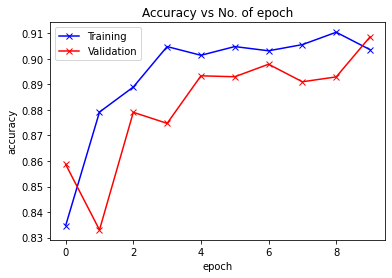

In [29]:
plot_accuracies(history_rn_pr)

In [31]:
# check
model = models.resnet18(weights = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))
model.load_state_dict(torch.load('resnet_pretrained.pt'))
model.eval()

for idx, data in enumerate(val_dl):
  out = model(data[0])
  _, y_hat = out.max(1)
  print(y_hat)
  print(data[1])
  break


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([6, 1, 1, 8, 7, 5, 8, 9, 4, 4, 4, 7, 8, 0, 0, 9, 6, 1, 2, 1, 5, 5, 4, 2,
        5, 7, 8, 8, 4, 6, 8, 6, 6, 2, 5, 8, 0, 1, 2, 4, 0, 2, 2, 4, 9, 0, 1, 9,
        8, 0, 7, 6, 9, 2, 4, 2, 9, 0, 2, 8, 6, 8, 8, 5])
tensor([6, 1, 1, 8, 7, 5, 8, 9, 5, 4, 4, 7, 8, 0, 7, 9, 6, 1, 2, 1, 5, 9, 4, 2,
        5, 7, 7, 0, 4, 6, 8, 6, 6, 2, 5, 1, 0, 1, 2, 5, 0, 2, 2, 5, 9, 0, 1, 9,
        8, 0, 7, 6, 9, 2, 4, 2, 9, 0, 2, 8, 6, 8, 8, 5])
